In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
import astropy.coordinates as coord

In [2]:
#load px, py, pz (cartesian heliocentric positions) 
HCx = np.loadtxt("matt_px") #kpc
HCy = np.loadtxt("matt_py") #kpc
HCz = np.loadtxt("matt_pz") #kpc

#load vx, vy, vz (cartesian heliocentric velocities) 
HCxvel = np.loadtxt("matt_vx") #km/s
HCyvel = np.loadtxt("matt_vy") #km/s
HCzvel = np.loadtxt("matt_vz") #km/s

#load galactic longitude and latitudes
HCglat = np.loadtxt("matt_glat")
HCglon = np.loadtxt("matt_glon")
HCrad = np.loadtxt("matt_rad")
#load position and velocity of sun (cartesian galactocentric coordinates)
#first three values are positions in kpc
#last three values are velocities in km/s
sun = np.loadtxt("matt_center") 

#convert from heliocentric to galactocentric coordinates
GCx = (HCx + sun[0]) * u.kpc
GCy = (HCy + sun[1]) * u.kpc
GCz = (HCz + sun[2]) * u.kpc
GCxvel = (HCxvel + sun[3]) * u.km/u.s
GCyvel = (HCyvel + sun[4]) * u.km/u.s
GCzvel = (HCzvel + sun[5]) * u.km/u.s

sunpos = sun[0:3] * u.kpc
sunvel = coord.CartesianDifferential(sun[3:6]) * u.km/u.s

In [60]:
print("The original file has", len(HCx), "stars.")

#reduce the number of stars to make it more manageable

i = 100

x = HCx[0::i]
y = HCy[0::i]
z = HCz[0::i]
xvel = HCxvel[0::i]
yvel = HCyvel[0::i]
zvel = HCzvel[0::i]
glat = HCglat[0::i]
glon = HCglon[0::i]
#rad = HCrad[0::i]

print("The sample has", len(x), "stars.")

The original file has 1298622 stars.
The sample has 12987 stars.


In [34]:
def plot_pm(x, y, z, xvel, yvel, zvel, binwidth):
    nstars = len(x)
    print('Number of stars:', nstars)

    radius_vec = np.array([x, y, z])
    velocity_vec = np.array([xvel, yvel, zvel])
    radius = np.linalg.norm(radius_vec, axis = 0) #same as radius = np.sqrt(HCx**2 + HCy**2 + HCz**2)
    r_hat = radius_vec/radius
    v_dot_r_hat = np.sum(velocity_vec * r_hat, axis = 0)
    pm = np.linalg.norm(velocity_vec - v_dot_r_hat * r_hat, axis = 0)/(4.74 * radius)

    dr = binwidth
    rbins = np.arange(0, 20, dr)
    averagemotion = np.zeros(len(rbins), dtype=float)
    veldispersion = np.zeros(len(rbins), dtype=float)

    for i in range(len(rbins)):
        propermotions = pm[(radius > rbins[i]) & (radius <= rbins[i] + dr)]
        if len(propermotions) == 0:
            averagemotion[i] = 'nan' #0
            veldispersion[i] = 'nan' #0
        else:
            averagemotion[i] = np.mean(propermotions)
            veldispersion[i] = np.std(propermotions)
    radialdist = rbins + dr/2.0

    plt.plot(radialdist, averagemotion, '.')
    plt.fill_between(radialdist, averagemotion-veldispersion, averagemotion+veldispersion, alpha=0.2, color='red')
    plt.xlim(0, 12)
    plt.xlabel("Distance from Sun (kpc)")
    plt.ylabel("Mean proper Motion (mas/year)")
    plt.title("Mean proper motion vs Distance from Sun, HC coords")
    plt.show()

In [57]:
def plot_pm_l(x, y, z, xvel, yvel, zvel, binwidth):
    nstars = len(x)
    print('Number of stars:', nstars)
    
    radius_vec = np.array([x, y, z])
    radius = np.linalg.norm(radius_vec, axis = 0) #same as radius = np.sqrt(HCx**2 + HCy**2 + HCz**2)
    
    #input in galactocentric coordinates
    panda = coord.Galactocentric(x=GCx, y=GCy, z=GCz, v_x=GCxvel, v_y=GCyvel, v_z=GCzvel, galcen_distance = sunpos[0], z_sun = sunpos[2], galcen_v_sun = sunvel)

    #go back to galactic/heliocentric coordinates
    galactic = panda.transform_to(coord.Galactic)

    #get proper motions in l and b
    #l and b are given in degrees
    #pm_l_cosb and pm_b are given in mas/year
    propermotionlcosb = np.array(galactic.pm_l_cosb)
    propermotionb = np.array(galactic.pm_b)
    propermotionl = propermotionlcosb/np.cos(np.pi * propermotionb / 180)

    dr = binwidth
    rbins = np.arange(0, 20, dr)
    averagemotion = np.zeros(len(rbins), dtype=float)
    veldispersion = np.zeros(len(rbins), dtype=float)
    absaveragemotion = np.zeros(len(rbins), dtype=float)
    absveldispersion = np.zeros(len(rbins), dtype=float)

    for i in range(len(rbins)):
        propermotions = propermotionl[(radius > rbins[i]) & (radius <= rbins[i] + dr)]
        abspropermotions = np.abs(propermotionl[(radius > rbins[i]) & (radius <= rbins[i] + dr)])
        if len(propermotions) == 0:
            averagemotion[i] = 'nan' #0
            veldispersion[i] = 'nan' #0
            absaveragemotion[i] = 'nan' #0
            absveldispersion[i] = 'nan' #0
        else:
            averagemotion[i] = np.mean(propermotions)
            veldispersion[i] = np.std(propermotions)
            absaveragemotion[i] = np.mean(propermotions)
            absveldispersion[i] = np.std(propermotions)
    radialdist = rbins + dr/2.0

    plt.plot(radialdist, averagemotion, '.')
    plt.fill_between(radialdist, averagemotion-veldispersion, averagemotion+veldispersion, alpha=0.2, color='red')
    plt.xlim(0, 12)
    plt.ylim(-2,30)
    plt.xlabel("Distance from Sun (kpc)")
    plt.ylabel("Mean proper Motion (mas/year)")
    plt.title("Mean proper motion vs Distance from Sun, HC coords")
    plt.show()
    
    plt.plot(radialdist, absaveragemotion, '.')
    plt.fill_between(radialdist, absaveragemotion-absveldispersion, absaveragemotion+absveldispersion, alpha=0.2, color='red')
    plt.xlim(0, 12)
    plt.ylim(-2,30)
    plt.xlabel("Distance from Sun (kpc)")
    plt.ylabel("Mean proper Motion (mas/year)")
    plt.title("Mean proper motion vs Distance from Sun, HC coords")
    plt.show()
    
    plt.hist(propermotionl)
    plt.title("propermotionl")
    plt.yscale('log')
    plt.xlim(-10,10)
    plt.show()

In [58]:
def plot_pm_b(x, y, z, xvel, yvel, zvel, binwidth):
    nstars = len(x)
    print('Number of stars:', nstars)
    
    radius_vec = np.array([x, y, z])
    radius = np.linalg.norm(radius_vec, axis = 0) #same as radius = np.sqrt(HCx**2 + HCy**2 + HCz**2)
    
    #input in galactocentric coordinates
    panda = coord.Galactocentric(x=GCx, y=GCy, z=GCz, v_x=GCxvel, v_y=GCyvel, v_z=GCzvel, galcen_distance = sunpos[0], z_sun = sunpos[2], galcen_v_sun = sunvel)

    #go back to galactic/heliocentric coordinates
    galactic = panda.transform_to(coord.Galactic)

    #get proper motions in l and b
    #l and b are given in degrees
    #pm_l_cosb and pm_b are given in mas/year
    propermotionlcosb = np.array(galactic.pm_l_cosb)
    propermotionb = np.array(galactic.pm_b)
    propermotionl = propermotionlcosb/np.cos(np.pi * propermotionb / 180)

    dr = binwidth
    rbins = np.arange(0, 20, dr)
    averagemotion = np.zeros(len(rbins), dtype=float)
    veldispersion = np.zeros(len(rbins), dtype=float)
    absaveragemotion = np.zeros(len(rbins), dtype=float)
    absveldispersion = np.zeros(len(rbins), dtype=float)

    for i in range(len(rbins)):
        propermotions = propermotionb[(radius > rbins[i]) & (radius <= rbins[i] + dr)]
        abspropermotions = np.abs(propermotionb[(radius > rbins[i]) & (radius <= rbins[i] + dr)])
        if len(propermotions) == 0:
            averagemotion[i] = 'nan' #0
            veldispersion[i] = 'nan' #0
            absaveragemotion[i] = 'nan' #0
            absveldispersion[i] = 'nan' #0
        else:
            absaveragemotion[i] = np.mean(abspropermotions)
            absveldispersion[i] = np.std(abspropermotions)
            averagemotion[i] = np.mean(propermotions)
            veldispersion[i] = np.std(propermotions)
    radialdist = rbins + dr/2.0

    plt.plot(radialdist, averagemotion, '.')
    plt.fill_between(radialdist, averagemotion-veldispersion, averagemotion+veldispersion, alpha=0.2, color='red')
    plt.xlim(0, 12)
    plt.ylim(-5,5)
    plt.xlabel("Distance from Sun (kpc)")
    plt.ylabel("Mean proper Motion (mas/year)")
    plt.title("Mean proper motion vs Distance from Sun, HC coords")
    plt.show()
    
    plt.plot(radialdist, absaveragemotion, '.')
    plt.fill_between(radialdist, absaveragemotion-absveldispersion, absaveragemotion+absveldispersion, alpha=0.2, color='red')
    plt.xlim(0, 12)
    plt.ylim(-2,30)
    plt.xlabel("Distance from Sun (kpc)")
    plt.ylabel("Mean proper Motion (mas/year)")
    plt.title("Mean proper motion vs Distance from Sun, HC coords")
    plt.show()
    
    plt.hist(propermotionb)
    plt.title("propermotionb")
    plt.yscale('log')
    plt.xlim(-10,10)
    plt.show()

Number of stars: 12987


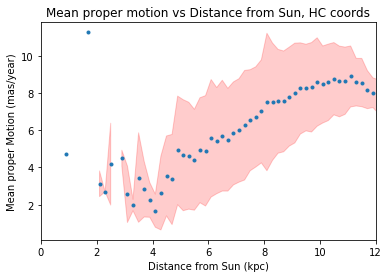

Number of stars: 12987


/home/casey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1298622 but corresponding boolean dimension is 12987
/home/casey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1298622 but corresponding boolean dimension is 12987


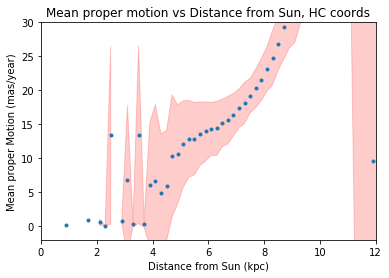

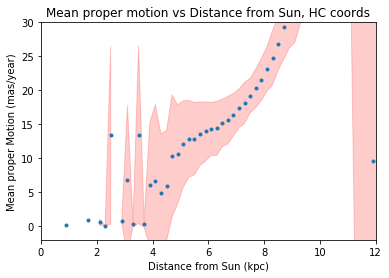

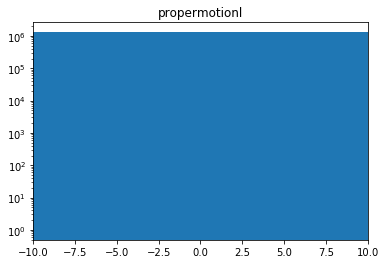

Number of stars: 12987


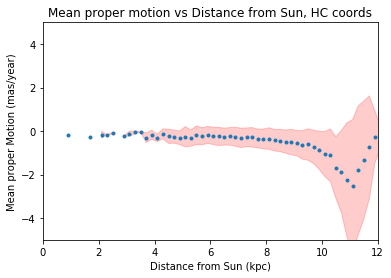

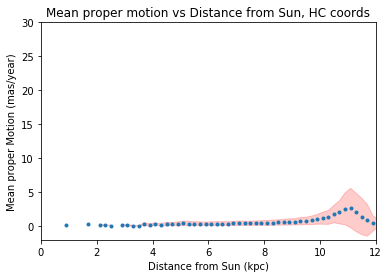

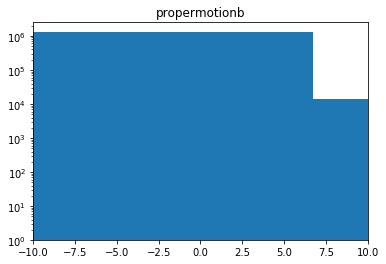

In [61]:
plot_pm(x=x, y=y, z=z, xvel=xvel, yvel=yvel, zvel=zvel, binwidth=0.2)
plot_pm_l(x=x, y=y, z=z, xvel=xvel, yvel=yvel, zvel=zvel, binwidth=0.2)
plot_pm_b(x=x, y=y, z=z, xvel=xvel, yvel=yvel, zvel=zvel, binwidth=0.2)